# Stock Market Prediction using Time-series and Daily News Text Analysis

## Preprocessing and Modeling

In [79]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,6

pd.set_option('mode.chained_assignment', 'raise') # Raise an exception, warn, or no action if trying to use chained assignment

### Load combined stock index dataset

In [80]:
# Read the combined stock index CSV data file from the data directory
dataset = pd.read_csv('data/comb_data_final.csv', index_col='Date', parse_dates=True)

In [81]:
# Tops 3 rows of the dataset
dataset.head(3)

,Open,High,Low,Close,Volume,Adj Close,Label,Top1,Top2,Top3,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."


In [82]:
# Combine the 25 text columns into one column for each row
comb_headlines = []
for row in range(0,len(dataset.index)):
    comb_headlines.append(' '.join(str(x) for x in dataset.iloc[row,7:27]))
# Make it a column in the dataset
dataset['comb_headlines']=comb_headlines

### Load necessary NLP libraries

In [83]:
import nltk
import string
import re
import gensim
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

### Clean and Tokenize text for preprocessing

In [84]:
# Build stopwords and punctuation data
stopwords = nltk.corpus.stopwords.words('english')
list_str_punct = list(string.punctuation)
extra_punctuation = ["b""", "\"", ".'", ".\""]

# Add extra punctuations to string.punctuation
for p in extra_punctuation:
    if p not in list_str_punct:
        list_str_punct.append(p)

# Write a text cleaning and word tokenizing function:
# Line 1: It takes all letters that are not in list_str_punct (punctuation), makes them lower case and joins them into a big string
# Line 2: Using regex W+, it creates word tokens
# Line 3: Reads word tokens and remove any stop words
def clean_text(text):
    text = ''.join([letter.lower() for letter in text if letter not in list_str_punct])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return tokens

In [85]:
# comb_headlines column before cleaning
dataset['comb_headlines'].head(3)

Date
2008-08-08    b"Georgia 'downs two Russian warplanes' as cou...
2008-08-11    b'Why wont America and Nato help us? If they w...
2008-08-12    b'Remember that adorable 9-year-old who sang a...
Name: comb_headlines, dtype: object

In [86]:
# first row
comb_headlines[0:1]

['b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Russia?\

In [87]:
# Clean and tokenize the combined headlines column
# We will keep the original unclean column for now
dataset['clean_comb_headlines'] = dataset['comb_headlines'].apply(lambda x: clean_text(x))
dataset['clean_comb_headlines'].head()

Date
2008-08-08    [georgia, downs, two, russian, warplanes, as, ...
2008-08-11    [why, wont, america, and, nato, help, us, if, ...
2008-08-12    [rememer, that, adorale, 9yearold, who, sang, ...
2008-08-13    [, us, refuses, israel, weapons, to, attack, i...
2008-08-14    [all, the, experts, admit, that, we, should, l...
Name: clean_comb_headlines, dtype: object

In [88]:
# Optional step: Clean each text column and replace the original columns
# NOT APPLIED: unknown float error in columns Top 23, 24, 25
# dataset["Top23_"]=dataset["Top23"].apply(lambda x: clean_text(x))
# cols = dataset.columns
# for col in cols:
#   if "Top" in col:
#       dataset[str(col)+"_"]=dataset[col].apply(lambda x: clean_text(x))
#       dataset.drop([col], axis=1, inplace=True)

In [89]:
dataset.head(3)

,Open,High,Low,Close,Volume,Adj Close,Label,Top1,Top2,Top3,...,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,comb_headlines,clean_comb_headlines
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,...,"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...","[georgia, downs, two, russian, warplanes, as, ..."
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",...,b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,"[why, wont, america, and, nato, help, us, if, ..."
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...",...,"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,"[rememer, that, adorale, 9yearold, who, sang, ..."


In [90]:
len(dataset)

1989

## Splitting Data into Train and Test

In [91]:
# Set the threshold two years before the last date (at the beginning of 7th year)
threshold = dataset.index.max() - pd.DateOffset(years=2) 
# Create Train and Test datasets
train = dataset[dataset.index <= threshold]
test = dataset[dataset.index > threshold]

X_train, X_test, y_train, y_test = train["clean_comb_headlines"], test["clean_comb_headlines"], train["Label"], test["Label"]

In [92]:
print(X_train.shape, y_train.shape)

(1484,) (1484,)


In [93]:
print(X_test.shape, y_test.shape)

(505,) (505,)


In [94]:
# Clean text X_train
X_train.head(3)

Date
2008-08-08    [georgia, downs, two, russian, warplanes, as, ...
2008-08-11    [why, wont, america, and, nato, help, us, if, ...
2008-08-12    [rememer, that, adorale, 9yearold, who, sang, ...
Name: clean_comb_headlines, dtype: object

In [95]:
# OPTIONAL
# Let's save the training and test sets to ensure we are using the same data for each model
X_train.to_csv('data/X_train.csv', index=False, header=True)
X_test.to_csv('data/X_test.csv', index=False, header=True)
y_train.to_csv('data/y_train.csv', index=False, header=True)
y_test.to_csv('data/y_test.csv', index=False, header=True)

## Baseline Model: TF-IDF Vectorizer

In [96]:
# Load the cleaned training and test sets
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

X_train.head()

,clean_comb_headlines
0,"['georgia', 'downs', 'two', 'russian', 'warpla..."
1,"['why', 'wont', 'america', 'and', 'nato', 'hel..."
2,"['rememer', 'that', 'adorale', '9yearold', 'wh..."
3,"['', 'us', 'refuses', 'israel', 'weapons', 'to..."
4,"['all', 'the', 'experts', 'admit', 'that', 'we..."


### Create TF-IDF Vectors

In [97]:
# Instantiate and fit a TFIDF vectorizer
# We are only fitting/training on the Train data and using that model to transform both train and test data sets
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train['clean_comb_headlines'])
X_train_vect = tfidf_vect.transform(X_train['clean_comb_headlines'])
X_test_vect = tfidf_vect.transform(X_test['clean_comb_headlines'])

In [98]:
# We can see the words that were learned by the vectorizer along with the index where the model stores the features internally
# Top 10 records in the vocabulary dict:
list(tfidf_vect.vocabulary_.items())[0: 10]

[('georgia', 12182),
 ('downs', 9034),
 ('two', 29400),
 ('russian', 24733),
 ('warplanes', 30876),
 ('as', 3447),
 ('countries', 7139),
 ('move', 18577),
 ('to', 28738),
 ('rink', 24112)]

In [99]:
# Output vectors are stored as sparse matrices, an efficient way to store matrices which most entries are zeros (by storing only non-zero entries and their location)
# Let's look at the first word in the test vector:
X_test_vect[0]
# Word: 'georgia' - vector is 31892 numbers long but only 207 of them are non-zero

<1x31892 sparse matrix of type '<class 'numpy.float64'>'
	with 207 stored elements in Compressed Sparse Row format>

In [100]:
# We can convert sparse matrix into an array using toarray() method
X_test_vect[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

### Fit RandomForest Classifier on TF-IDF

In [101]:
# Fit a basic Random Forest model on these vectors
rf = RandomForestClassifier(random_state=42) #max_depth?
rf_model = rf.fit(X_train_vect, y_train.values.ravel())
# sklearn expects labels (y) to be an array instead of panda's column vector
# We use values and ravel method that converts them to array

In [102]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect)

In [103]:
# Evaluate the predictions of the model on the holdout test set
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test['Label']).sum()/len(y_pred), 3)))
print("ROC Score:", round(roc_auc_score(y_test, y_pred),3))

Precision: 0.515 / Recall: 0.672 / Accuracy: 0.501
ROC Score: 0.494


### Trying other ML models (optional)

In [106]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [114]:
def all_classifier():
    clf = LogisticRegressionCV(Cs=[0.1,1.0,10.0], cv=5, solver='liblinear').fit(X_train_vect, y_train)
    print("Logistic Classifier", clf.score(X_test_vect, y_test))
    y_preds=clf.predict_proba(X_test_vect)
    y_preds = y_preds[:, 1]
    print("Logistic ROC Curve", roc_auc_score(y_test, y_preds))
    
    rclf = RandomForestClassifier(max_depth=10)
    rclf.fit(X_train_vect, y_train.values.ravel())
    print("RandomForest Classifier",rclf.score(X_test_vect, y_test))
    
    mnb = MultinomialNB()
    mnb.fit(X_train_vect, y_train.values.ravel())
    print("MultinomialNB Classifier", mnb.score(X_test_vect, y_test))
    
    boost = XGBClassifier()
    boost.fit(X_train_vect, y_train.values.ravel())
    y_pred = boost.predict(X_test_vect)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("XGBClassifier Accuracy: %.2f%%" % (accuracy * 100.0))

    return clf, rclf, mnb, boost

In [115]:
# Run the classifier models
a,b,c,d = all_classifier()

Logistic Classifier 0.5188118811881188
Logistic ROC Curve 0.5175289793610404
RandomForest Classifier 0.5188118811881188
MultinomialNB Classifier 0.5188118811881188
[14:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Accuracy: 49.70%


### Conclusion
This was our baseline model. We will explore other models and compare it to this baseline.
- Precision: When the model identified a combined headline as label value 1 (increase in stock index), it actually was right 51.5% of the time
- Recall: Of the combined headlines in the test set that were labeled as 1 (increase in stock index), model correctly identified 67.2% of them
- Accuracy: Whether the model predicted stock index increase or decrease, it was only correct 50.1% of the time, which is fairly low accuracy.

## Model 2: word2vec Vectors

In [55]:
# In this section, we will be using vectors created from word2vec instead of TF-IDF
# We will be using the gensim library to use the word2vec model

# Train a basic word2vec model
# We will create vectors of length 100, window of 5 words before and after the key word to understand context and we will learn a word vector for any words that appears at least twice in the training set
w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [56]:
# Replace the words in each combined headline with the learned word vector (turns each headline to a numeric vector)
# index2word attribute is the list of words the model has learned word vectors for and we are storing that in a set called words (all words that word2vec knows)
# Finally, we are cycling thru each word in each headline and return the word vector for that word and then we are converting the list to an array for elementwise averaging in the next step
words = set(w2v_model.wv.index2word)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train['clean_comb_headlines']])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test['clean_comb_headlines']])

In [57]:
# Average the word vectors for each sentence (and assign a vector of zeros if the model did not learn any of the words in the text message during training
# This is necessary for the ML model to work: Each headline should be represented the same way (vector size: 100)
# Any unlearned word will be represented by a vector of zeros
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [58]:
# Averaged version of the vector array
X_train_vect_avg[0]

array([-1.4155641e-03,  1.6659907e-03, -1.0690014e-03, -1.2518734e-03,
        2.4671422e-04, -1.6236576e-04, -2.7192513e-05, -1.0829717e-03,
        6.9087237e-04, -1.3384061e-03, -2.7790682e-03,  2.7665359e-03,
       -8.6568331e-04,  3.7756588e-04,  1.2457606e-03, -8.1179512e-04,
       -2.6765633e-03,  2.4366286e-03,  4.3618568e-04, -1.6870880e-03,
        1.2722824e-03,  1.5035862e-03,  8.1126619e-04, -6.7584077e-04,
       -1.1028734e-03, -2.3845169e-03, -8.3000876e-04,  4.3307751e-04,
        2.6185627e-04,  6.8453746e-04,  8.4334618e-04, -6.3028187e-05,
       -2.2649663e-03,  1.7341099e-03, -5.3640705e-04, -5.2858162e-04,
       -9.3744369e-05, -3.7408766e-04,  2.0618550e-03, -2.9468877e-04,
        9.5105107e-04,  1.9028989e-04,  2.0995210e-03,  2.9976512e-04,
       -1.2308687e-04,  4.9735485e-05,  8.9394231e-04,  1.7352365e-03,
       -1.6409442e-03,  3.7279224e-03, -1.8041469e-03,  7.2002230e-04,
       -4.1960506e-05, -1.5979201e-03,  2.1202657e-04,  3.1075671e-03,
      

In [59]:
# Size of single averaged vector array
len(X_train_vect_avg[0])

100

### Fit RandomForest Classifier on word2vec

In [60]:
# Instantiate and fit a basic Random Forest model on top of the word vectors
rf = RandomForestClassifier(random_state=42)
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [61]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [64]:
# Evaluate the predictions of the model on the holdout test set
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test['Label']).sum()/len(y_pred), 3)))
print("ROC Score:", round(roc_auc_score(y_test, y_pred),3))

Precision: 0.505 / Recall: 0.565 / Accuracy: 0.487
ROC Score: 0.484


### Conclusion
word2vec resulted in slightly worse performance scores probably because word2vec is not really intended to create representations of sentences and we are averaging word vectors to get a sentence level representation which causes loss of information.

## Model 3: doc2vec Vectors


In [65]:
# Create doc2vec Vectors
# We need to create TaggedDocument object before we train our model. Below we created TaggedDocument vectors for each combined headline in the training and test sets. We are using index of the headlines as the index of the tagged doc.
tagged_docs_train = [gensim.models.doc2vec.TaggedDocument(v, [i])
                     for i, v in enumerate(X_train['clean_comb_headlines'])]
tagged_docs_test = [gensim.models.doc2vec.TaggedDocument(v, [i])
                    for i, v in enumerate(X_test['clean_comb_headlines'])]

In [66]:
# First TaggedDocument object with words (words=) and the index (tags=[0])
tagged_docs_train[:1]

[TaggedDocument(words="['georgia', 'downs', 'two', 'russian', 'warplanes', 'as', 'countries', 'move', 'to', 'rink', 'of', 'war', 'breaking', 'musharraf', 'to', 'e', 'impeached', 'russia', 'today', 'columns', 'of', 'troops', 'roll', 'into', 'south', 'ossetia', 'footage', 'from', 'fighting', 'youtue', 'russian', 'tanks', 'are', 'moving', 'towards', 'the', 'capital', 'of', 'south', 'ossetia', 'which', 'has', 'reportedly', 'een', 'completely', 'destroyed', 'y', 'georgian', 'artillery', 'fire', 'afghan', 'children', 'raped', 'with', 'impunity', 'un', 'official', 'says', 'this', 'is', 'sick', 'a', 'three', 'year', 'old', 'was', 'raped', 'and', 'they', 'do', 'nothing', '150', 'russian', 'tanks', 'have', 'entered', 'south', 'ossetia', 'whilst', 'georgia', 'shoots', 'down', 'two', 'russian', 'jets', 'breaking', 'georgia', 'invades', 'south', 'ossetia', 'russia', 'warned', 'it', 'would', 'intervene', 'on', 'sos', 'side', 'the', 'enemy', 'comatent', 'trials', 'are', 'nothing', 'ut', 'a', 'sham', 

In [67]:
# Train a basic doc2vec model (we are using the same parametes as before)
d2v_model = gensim.models.Doc2Vec(tagged_docs_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [68]:
# Infer the vectors (infer_vector() method) to be used in training and testing to convert a list of words into a numeric representation using the trained model
# eval() lets us interpret the list in the string output in TaggedDocument 
train_vectors = [d2v_model.infer_vector(eval(v.words)) for v in tagged_docs_train] 

test_vectors = [d2v_model.infer_vector(eval(v.words)) for v in tagged_docs_test] 

### Fit RandomForest Classifier on doc2vec

In [69]:
# Fit a basic model, make predictions on the holdout test set, and the generate the evaluation metrics
rf = RandomForestClassifier(random_state=42)
rf_model = rf.fit(train_vectors, y_train.values.ravel())

y_pred = rf_model.predict(test_vectors)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test['Label']).sum()/len(y_pred), 3)))
print("ROC Score:", round(roc_auc_score(y_test, y_pred),3))

Precision: 0.492 / Recall: 0.603 / Accuracy: 0.471
ROC Score: 0.466


### Conclusion
doc2vec actually resulted in even worse performance scores compared to our baseline and word2vec models.

## Model 4: Basic RNN
### Prep data

In [70]:
# Import Keras libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

In [71]:
# Train the tokenizer and use that tokenizer to convert the list of tokens into to sequences of numbers where each number represents the index of word stored in the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_comb_headlines'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_comb_headlines'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_comb_headlines'])

In [72]:
# Pad the sequences so each sequence/vector is the same length
X_train_seq_padded = pad_sequences(X_train_seq,50)
X_test_seq_padded = pad_sequences(X_test_seq,50)

### Build And Evaluate RNN

In [73]:
# Define functions to calculate precision and recall
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [74]:
# Construct our basic RNN model framework
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1021728   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,031,137
Trainable params: 1,031,137
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [76]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train['Label'], 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
47/47 [==============================] - 2s 49ms/step - loss: 0.6913 - accuracy: 0.5377 - precision_m: 0.5491 - recall_m: 0.8489 - val_loss: 0.6927 - val_accuracy: 0.5188 - val_precision_m: 0.5194 - val_recall_m: 1.0000
Epoch 2/10
47/47 [==============================] - 2s 37ms/step - loss: 0.6626 - accuracy: 0.5916 - precision_m: 0.5868 - recall_m: 0.9677 - val_loss: 0.7249 - val_accuracy: 0.5307 - val_precision_m: 0.5265 - val_recall_m: 0.9657
Epoch 3/10
47/47 [==============================] - 2s 36ms/step - loss: 0.3470 - accuracy: 0.8996 - precision_m: 0.8931 - recall_m: 0.9389 - val_loss: 0.8888 - val_accuracy: 0.5347 - val_precision_m: 0.5559 - val_recall_m: 0.5349
Epoch 4/10
47/47 [==============================] - 2s 35ms/step - loss: 0.0576 - accuracy: 0.9858 - precision_m: 0.9858 - recall_m: 0.9874 - val_loss: 1.5456 - val_accuracy: 0.5109 - val_precision_m: 0.5711 - val_recall_m: 0.2219
Epoch 5/10
47/47 [==============================] - 2s 37ms/step - loss: 0.0

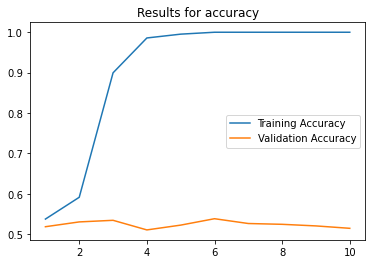

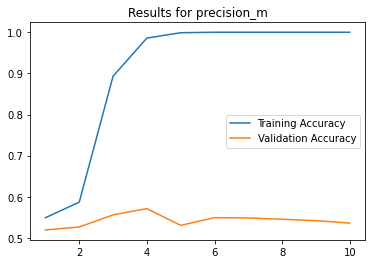

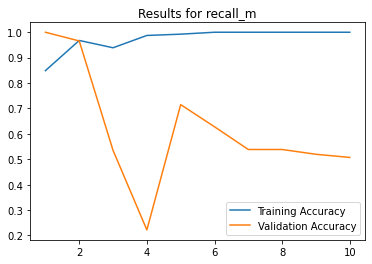

In [77]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

## Conclusion
The RNN Model is definitely an improvement over the word2vec and doc2vec models. If we consider the 5th epoch, the results for the validation set are: val_loss: 1.5490 - val_accuracy: 0.5228 - val_precision_m: 0.5305 - val_recall_m: 0.7150

Except for recall, all performance values have improved.


## Model Comparisons:
- TF_IDF: Precision: 0.515 / Recall: 0.672 / Accuracy: 0.501 / ROC: 0.494
- word2vec: Precision: 0.505 / Recall: 0.565 / Accuracy: 0.487 / ROC: 0.484
- doc2vec: Precision: 0.492 / Recall: 0.603 / Accuracy: 0.471 / ROC: 0.466
- RNN: Precision: 0.531 / Recall: 0.715 / Accuracy: 0.523

It seems like our baseline TF-IDF is still a very reasonable model and better than word2vec and doc2vec models.